# **10장 순환신경망에서 어텐션으로**
---
* 출판사 : 생능 출판사( http://www.booksr.co.kr/ )
* 으뜸 머신러닝 저자 : 강영민, 박동규, 김성수
*  소스코드 저장소 : https://github.com/dknife/ML2nd
*  저작권 : 본 노트북 코드는 자유롭게 배포가능하지만 위의 출판사, 저서, 저자표기와 함께 배포해 주십시오.
---

###  **LAB 10-2 어텐션 모델로 중요한 정보에 집중하자.**

In [18]:
import numpy as np
import matplotlib.pyplot as plt

size, seq_len = 300, 200
n_units = 128

# 비어있는 넘파이 배열을 생성한다.
# 이번에 생성할 데이터는 시퀀스에 인덱스가 있다
seq_X = np.empty(shape=(size, seq_len, 1))

np.random.seed(42)

# Generate sequences where each value is the previous value plus a random change
for i in range(size):
    # Random starting value between 0 and 10
    seq_X[i, 0, 0] = np.random.uniform(low=0, high=10)
    for j in range(1, seq_len):
        # Add a random value between -1 and 1 to the previous element
        seq_X[i, j, 0] = seq_X[i, j-1, 0] \
                         + np.random.uniform(low=-3, high=3)

n = seq_len
weights = 2 * (n - np.arange(seq_len)) / (n * (n + 1))
y = np.sum(seq_X.squeeze() * weights, axis=1)


train_size = int(size * 0.8)
train_X = seq_X[:train_size]
train_y = y[:train_size].reshape(-1,1)
test_X = seq_X[train_size:]
test_y = y[train_size:].reshape(-1,1)

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

# -------------------------------
# Attention-only 모델 정의
# -------------------------------
class AttentionWeightedSum(layers.Layer):
    def __init__(self, dim=64):
        super().__init__()
        self.dim = dim
        # 고정된 learnable query: (1, 1, dim)
        self.query = self.add_weight(
            shape=(1, 1, dim),
            initializer='glorot_uniform',
            trainable=True,
            name='global_query'
        )
        self.dense_k = layers.Dense(dim, use_bias=False)
        self.dense_v = layers.Dense(dim, use_bias=False)
        self.dense_out = layers.Dense(1)  # 여기도 레이어로 분리

    def call(self, inputs):
        # inputs: (batch, seq_len, embed_dim) → 여기서는 (batch, seq_len, 64)
        batch_size = tf.shape(inputs)[0]

        # Key, Value 생성
        k = self.dense_k(inputs)  # (batch, seq_len, dim)
        v = self.dense_v(inputs)  # (batch, seq_len, dim)

        # Query: (1, 1, dim) → (batch, 1, dim)로 확장
        q = tf.tile(self.query, [batch_size, 1, 1])  # (batch, 1, dim)

        # Scaled Dot-Product Attention
        scores = tf.matmul(q, k, transpose_b=True)  # (batch, 1, seq_len)
        d_k = tf.cast(self.dim, tf.float32)
        attention_weights = tf.nn.softmax(scores / tf.math.sqrt(d_k), axis=-1)

        # Weighted sum
        weighted = tf.matmul(attention_weights, v)  # (batch, 1, dim)
        weighted = tf.squeeze(weighted, axis=1)     # (batch, dim)

        # 최종 출력
        output = self.dense_out(weighted)           # (batch, 1)
        return output, attention_weights

In [20]:
# -------------------------------
# 모델 구성
# -------------------------------
inputs = layers.Input(shape=(seq_len, 1))
x = layers.Dense(64, activation='relu')(inputs)  # 임베딩
output, attn_weights = AttentionWeightedSum(dim=64)(x)

attention_model = models.Model(inputs, output)
attention_model.compile(optimizer='adam', loss='mse')
attention_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 200, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 200, 64)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_weighted_sum_10       │ [(None, 1), (None, 1,  │         8,321 │
│ (AttentionWeightedSum)          │ 200)]                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,449 (33.00 KB)

 Trainable params: 8,449 (33.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# 학습
history = attention_model.fit(train_X, train_y, epochs=25, batch_size=16, verbose=1)

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 79.3413
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.5720 
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4074 
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2676 
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9114 
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4783 
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7426 
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0589 
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8370 
Epoch 10/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4578 
Epoch 11/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0991 
Epoch 12/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2599 
Epoch 13/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2374 
Epoch 14/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4902 
Epoch 15/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0432 
Epo

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


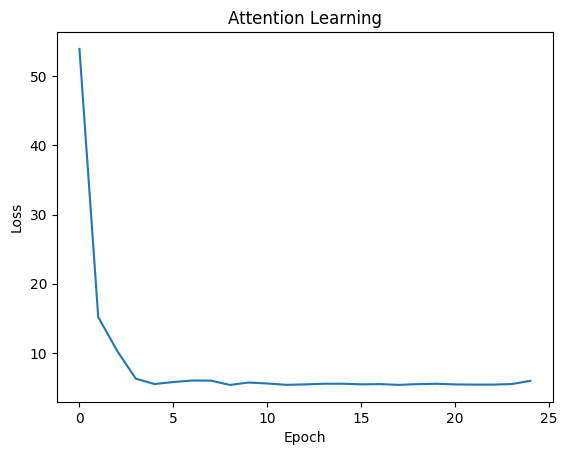

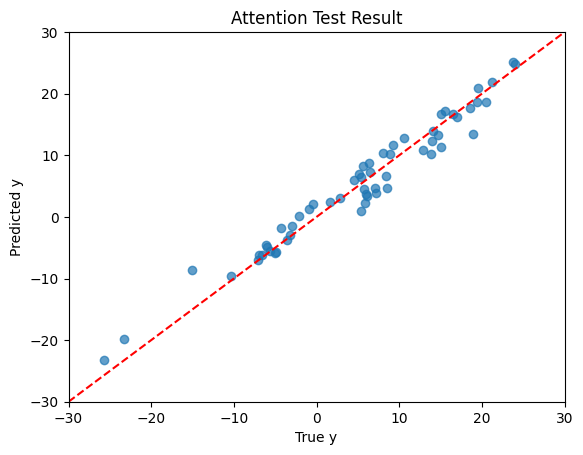

In [22]:
y_hat = attention_model.predict(test_X)

# 시각화
plt.plot(history.history['loss'])
plt.title("Attention Learning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.scatter(test_y, y_hat, alpha=0.7)
plt.title("Attention Test Result")
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.plot([-30,30],[-30,30],'r--')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step


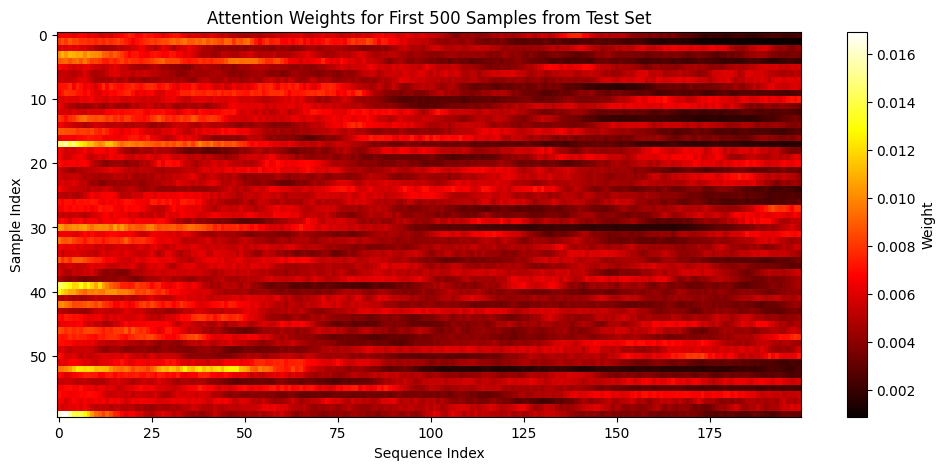

In [32]:
# 어텐션 가중치를 출력하는 모델 만들기
attention_weights_model = models.Model(inputs=attention_model.inputs,
                                       outputs=attn_weights)

# Get attention weights for the first n samples from the test set
n = 500
sample_inputs = test_X[0:n]  # Take the first n samples
sample_attention_weights = attention_weights_model.predict(sample_inputs)

# 어텐션 가중치를 차트로 그릴 수 있게 크기 조정
# 원래 크기 (batch_size, 1, seq_len) -> (batch_size, seq_len)
sample_attention_weights = sample_attention_weights.squeeze()

# 행은 몇 번째 시퀀스인지를 나타내고, 열은 시퀀스 내에서의 원소 위치
plt.figure(figsize=(12, 5))
plt.imshow(sample_attention_weights, aspect="auto", cmap="hot")
plt.title(f"Attention Weights for First {n} Samples from Test Set")
plt.xlabel("Sequence Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Weight")
plt.show()

### **RNN, LSTM, GRU와 비교**

In [24]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=n_units, input_shape=(seq_len, 1), return_sequences=False),
    tf.keras.layers.Dense(1)  # 출력: 다음 값 예측
])

LSTM_model = tf.keras.Sequential([
   tf.keras.layers.LSTM(units = n_units, return_sequences=False,
                        input_shape=[seq_len, 1]),
   tf.keras.layers.Dense(1)
])

GRU_model = tf.keras.Sequential([
    tf.keras.layers.GRU(units = n_units, return_sequences=False,
                        input_shape=[seq_len, 1]),
    tf.keras.layers.Dense(1)
])

rnn_model.compile(optimizer ='adam', loss = 'mse')
LSTM_model.compile(optimizer ='adam', loss = 'mse')
GRU_model.compile(optimizer ='adam', loss = 'mse')

rnn_model.fit(train_X, train_y, epochs=25)
LSTM_model.fit(train_X, train_y, epochs=25)
GRU_model.fit(train_X, train_y, epochs=25)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 116.2681
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 96.0349
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 90.0138
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 74.0363
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 71.0568
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 72.7611
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 67.7539
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 63.9025
Epoch 9/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 62.3751
Epoch 10/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 70.2217
Epoch 11/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 58.6708
Epoch 12/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 67.1723
Epoch 13/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 65.1984
Epoch 14/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 52.3689
Epoch 15/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 54.7068
Epoch 16/25
8/8 ━

In [25]:
y_hat_rnn = rnn_model.predict(test_X)
y_hat_lstm = LSTM_model.predict(test_X)
y_hat_gru = GRU_model.predict(test_X)
y_hat_attention = attention_model.predict(test_X)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


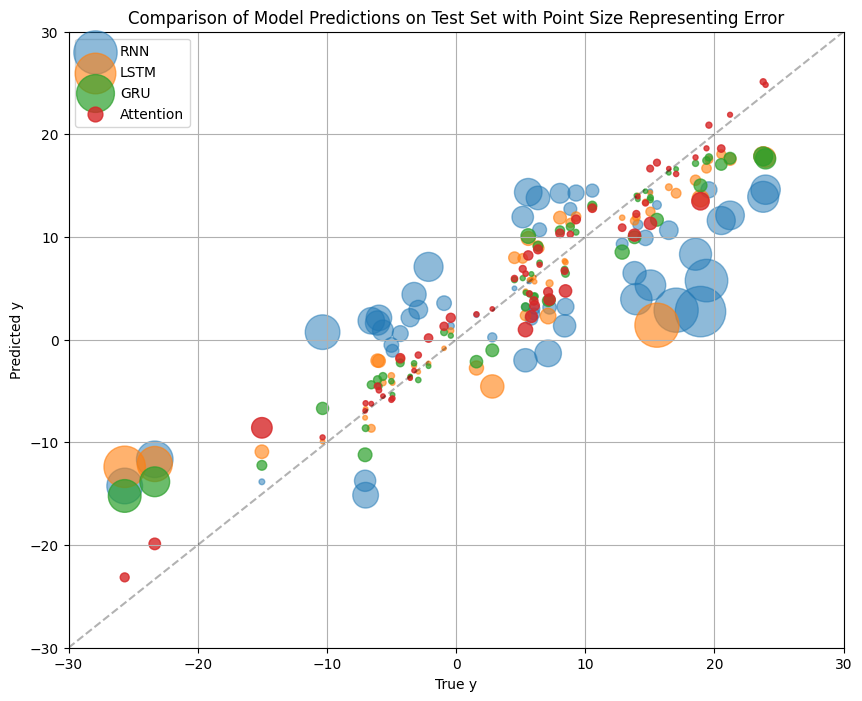

In [26]:

plt.figure(figsize=(10, 8))

# 각 모델의 오차를 계산
error_rnn = np.abs(test_y - y_hat_rnn)**2
error_lstm = np.abs(test_y - y_hat_lstm)**2
error_gru = np.abs(test_y - y_hat_gru)**2
error_attention = np.abs(test_y - y_hat_attention)**2

# 각 모델의 오차에 따라 점의 크기를 결정
size_rnn = error_rnn * 5 + 10
size_lstm = error_lstm * 5 + 10
size_gru = error_gru * 5 + 10
size_attention = error_attention * 5 + 10

# Plot RNN results
plt.scatter(test_y, y_hat_rnn, alpha=0.5, label='RNN', s=size_rnn)

# Plot LSTM results
plt.scatter(test_y, y_hat_lstm, alpha=0.6, label='LSTM', s=size_lstm)

# Plot GRU results
plt.scatter(test_y, y_hat_gru, alpha=0.7, label='GRU', s=size_gru)

# Plot Attention results
plt.scatter(test_y, y_hat_attention, alpha=0.8, label='Attention', s=size_attention)

plt.plot([-30,30], [-30, 30], 'k--', alpha=0.3)

plt.title("Comparison of Model Predictions on Test Set with Point Size Representing Error")
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.legend()
plt.grid(True)
plt.show()
